# Decode trial type for each individual animal

In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [208]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_by_animal_ALL'

In [6]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [369]:
#this will cause text to be exported as 'true text' which can be edited in Adobe Illustrator
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42

In [7]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [8]:
import h5py

def do_decoding_combined_within(patterns, labels, n_loops=20, ncells=None, cellreg=False, n_steps=15, **args):
     
    scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in patterns.keys()])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    patterns_t={}
    patterns_T={}
    labels_t={}
    labels_T={}
    not_run=[]
    for ani in patterns.keys():
        #only analyze if have > 5 trials of each trial type
        if (np.shape(np.where(labels[ani]==classes[0]))[-1]>=5) and (np.shape(np.where(labels[ani]==classes[1]))[-1]>=5): #only include animal if it has x trials of specified trial type
            which_trains = []
            which_tests = []
            #find min number of trials of both trial types, then downsample the type with more trials to match min
            min_trials1=np.sum(labels[ani]==classes[0])
            min_trials2=np.sum(labels[ani]==classes[1])
            min_trials=min(min_trials1,min_trials2)
            for l in classes:
                if l>=0:                    
                    wt = np.random.permutation(np.where(labels[ani]==l)[0])[:min_trials]
                    if train_test_split<1: #split trials into train and test subsets (ratio set by "train_test_split" value)
                        wT = wt[:int(len(wt)*train_test_split)]
                        which_trains.append(wt[int(len(wt)*train_test_split):])
                        which_tests.append(wT)
                    else:
                        which_trains.append(wt)
            which_train[ani] = np.concatenate(which_trains)
            if train_test_split<1:
                which_test[ani] = np.concatenate(which_tests)
        else:
            not_run.append(ani)
    for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
        #patterns_t[ani] = patterns[ani].copy()
        #labels_t[ani] = labels[ani].copy()
        #print which_train.keys()
    #for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
    #    print ani
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = combine_patterns(patterns_t, labels_t, classes=classes)

        
    if train_test_split<1:
        for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
            #patterns_T[ani] = patterns[ani].copy()
            #labels_T[ani] = labels[ani].copy()
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0],not_run,which_cells)
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None,not_run,which_cells)

def do_test_within(patterns, labels, **args):
    x, y, xT, yT,not_run,which_cells = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    scores = decoder.score(xT,yT)
    decoder.fit(xT,yT)
    return np.append(scores, decoder.score(x,y)) 

def Not_Run(patterns, labels, **args):
    x, y, xT, yT,not_run,which_cells = combine_train_test_patterns(patterns, labels, **args)
    return not_run,sum(which_cells)
        
def load_cellreg(animal, filename='pre_vs_post.mat', keys=['pre', 'post']):
    with h5py.File('../%s/data/%s'%(animal, filename), 'r') as f:
        g = np.r_[f['cell_registered_struct']['cell_to_index_map']]
        cellreg_dict = {k:g[i][np.where(np.prod([gg>0 for gg in g], 0))[0]].astype(int)-1
                        for i, k in enumerate(keys)}
    return cellreg_dict

def combine_patterns(patterns, labels, n_patterns=100, classes=[0, 1], labels_mask=None):
    labels_comb = np.r_[list(classes)*n_patterns]
    patterns_comb_train = []
    for i in xrange(n_patterns):
        for odor in classes:
            try:
                p = np.concatenate([patterns[ani][np.random.choice([w for w in np.where(labels[ani]==odor)[0]])]
                                for ani in patterns.keys()])
                patterns_comb_train.append(p)
            except:
                #print "no %s labels"%odor,
                continue
    return np.r_[patterns_comb_train], labels_comb

In [9]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [11]:
from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001)):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    ax.add_line(line)
    ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4)
    return sig_value, p

In [165]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=15, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            '' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [325]:
def report_stats (array1, array2, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
        U = sig_func(array1, array2)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        p = sig_func(array1, array2)[-1]
        print "U =",U,"p =",p*mcc,"r =",r
    if sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_ind(x, y)
        cohens_d = (np.mean(array1)-np.mean(array2))/np.sqrt((np.std(array1)**2+np.std(array2)**2)/2)
        p = sig_func(array1, array2)[-1]
        print sig_func(array1, array2),"d =", cohens_d, 'corrected p =',p*mcc

def report_stats_chance (array1, chance=0.5, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        U = sig_func(subtracted)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        print sig_func(subtracted),"r =",r
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        cohens_d = (np.mean(array1)-chance)/np.std(array1)
        print sig_func(array1,chance),"d =",cohens_d

In [13]:
dhpc_all_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_expo_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_pre_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36', #,'dhpcg20' #dHPC20 performed very well on day 1 (d' = 2)
dhpc_d2_animals =  'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_post_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_renew_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_ext2_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'
dhpc_ext1_animals = 'dhpcg1','dhpc24','dhpc35','dhpc36','dhpcg20'

vhpc_all_animals  = np.loadtxt('../allmice.txt', dtype=str)
vhpc_expo_animals = np.loadtxt('../expo_mice.txt', dtype=str)
vhpc_pre_animals  = np.loadtxt('../pre_mice.txt', dtype=str)
vhpc_d2_animals =  'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m8', '90', '91', '92','93'
vhpc_post_animals = np.loadtxt('../post_mice.txt', dtype=str)
vhpc_renew_animals ='c3f3','c3f2','c3m1', 'c3m2', 'c4m3',         'c10m8', '90', '91', '92','93','91b','92b','93b'
vhpc_ext2_animals = np.loadtxt('../ext2_mice.txt', dtype=str)
vhpc_ext1_animals = np.loadtxt('../ext1_mice.txt', dtype=str)

In [17]:
sessions = 'expo', 'pre', 'd2', 'post', 'ext1', 'ext2', 'renew'
regions = 'dhpc','vhpc'
dark_co = ('forestgreen','darkcyan','rebeccapurple','firebrick','lightgrey','dimgrey','goldenrod')
alt_co = ('hotpink','mediumorchid','darkturquoise','mediumspringgreen','lawngreen','khaki')
session_labels = ('Pre','Early','Day2','Late','Ext1','Ext2','Reinstate')
n_loops=20

In [15]:
for reg in regions:
    for sess in sessions:
        if sess == 'expo':
            exec("patterns_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('patterns_tb',\
                                                           '../%%s/2_odor_expo/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_%s_animals]))"%(reg,sess,reg,sess,reg,sess))
            exec("labels_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/2_odor_expo/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_%s_animals]))"%(reg,sess,reg,sess,reg,sess))
        else:
            exec("patterns_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('patterns_tb',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_%s_animals]))"%(reg,sess,reg,sess,sess,reg,sess))
            exec("labels_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_%s_animals]))"%(reg,sess,reg,sess,sess,reg,sess))

In [16]:
for reg in regions:
    for sess in sessions:
        for t in range(16):
                exec('patterns_%s_%s_%s = {}'%(reg,sess,t))
                for ani in eval('%s_%s_animals'%(reg,sess)):
                    try:
                        #print sess, tb, ani,
                        exec("patterns_%s_%s_%s['%s'] = patterns_%s_%s['%s'][%s]"%(reg,sess,t,ani,reg,sess,ani,t))
                    except:
                        print 'NOPE',reg,sess, tb, ani
                        continue

In [61]:
%%time
#for time bins durations of 0.5 and 1s, predict odor delivered for each bin. Repeat n times (where n = loops). This takes a while
print "number loops =",n_loops
for reg in regions:
    print reg,"...  ",
    for t in range(16): # number of time bins
        exec("scores_gmin_%s_%s={}"%(reg,t))
        for sess in sessions:
            eval("scores_gmin_%s_%s"%(reg,t))[sess] = np.r_[[do_test_within(eval("patterns_%s_%s_%s"%(reg,sess,t)),
                        eval("labels_%s_%s"%(reg,sess)),classes=[0,1], n_cells=454, relabel=None) for i in range(n_loops)]]

number loops = 20
dhpc expo ...   vhpc renew ...  CPU times: user 5min 1s, sys: 464 ms, total: 5min 1s
Wall time: 5min 1s



In [62]:
scores_gmin_dhpc_0

{'d2': array([[ 0.435,  0.355],
        [ 0.45 ,  0.42 ],
        [ 0.535,  0.48 ],
        [ 0.485,  0.49 ],
        [ 0.35 ,  0.515],
        [ 0.44 ,  0.53 ],
        [ 0.455,  0.375],
        [ 0.565,  0.525],
        [ 0.44 ,  0.54 ],
        [ 0.57 ,  0.495],
        [ 0.525,  0.385],
        [ 0.42 ,  0.555],
        [ 0.37 ,  0.485],
        [ 0.515,  0.555],
        [ 0.405,  0.49 ],
        [ 0.68 ,  0.665],
        [ 0.395,  0.44 ],
        [ 0.435,  0.455],
        [ 0.45 ,  0.38 ],
        [ 0.57 ,  0.5  ]]), 'expo': array([[ 0.535,  0.615],
        [ 0.53 ,  0.625],
        [ 0.57 ,  0.475],
        [ 0.5  ,  0.46 ],
        [ 0.36 ,  0.445],
        [ 0.42 ,  0.295],
        [ 0.635,  0.345],
        [ 0.625,  0.64 ],
        [ 0.425,  0.36 ],
        [ 0.615,  0.575],
        [ 0.425,  0.49 ],
        [ 0.41 ,  0.505],
        [ 0.7  ,  0.56 ],
        [ 0.645,  0.605],
        [ 0.57 ,  0.64 ],
        [ 0.49 ,  0.505],
        [ 0.44 ,  0.44 ],
        [ 0.505,  0.445

In [28]:
for reg in regions:
    for sess in sessions:
        exec("not_run,total_cells_%s_%s = Not_Run(patterns_%s_%s_6,labels_%s_%s,classes=[0,1], n_cells=None,\
              relabel=None)"%(reg,sess,reg,sess,reg,sess))
        print reg,sess
        print "NOT INCLUDED IN ANALYSIS (too few trials):"
        print "total cells =",eval("total_cells_%s_%s"%(reg,sess)),"\n"

dhpc expo
NOT INCLUDED IN ANALYSIS (too few trials):
total cells = 817 

dhpc pre
NOT INCLUDED IN ANALYSIS (too few trials):
total cells = 729 

dhpc d2
NOT INCLUDED IN ANALYSIS (too few trials):
total cells = 922 

dhpc post
NOT INCLUDED IN ANALYSIS (too few trials):
total cells = 1027 

dhpc ext1
NOT INCLUDED IN ANALYSIS (too few trials):
total cells = 911 

dhpc ext2
NOT INCLUDED IN ANALYSIS (too few trials):
total cells = 928 

dhpc renew
NOT INCLUDED IN ANALYSIS (too few trials):
total cells = 894 

vhpc expo
NOT INCLUDED IN ANALYSIS (too few trials):
total cells = 563 

vhpc pre
NOT INCLUDED IN ANALYSIS (too few trials):
total cells = 521 

vhpc d2
NOT INCLUDED IN ANALYSIS (too few trials):
total cells = 568 

vhpc post
NOT INCLUDED IN ANALYSIS (too few trials):
total cells = 454 

vhpc ext1
NOT INCLUDED IN ANALYSIS (too few trials):
total cells = 475 

vhpc ext2
NOT INCLUDED IN ANALYSIS (too few trials):
total cells = 518 

vhpc renew
NOT INCLUDED IN ANALYSIS (too few trials):
t

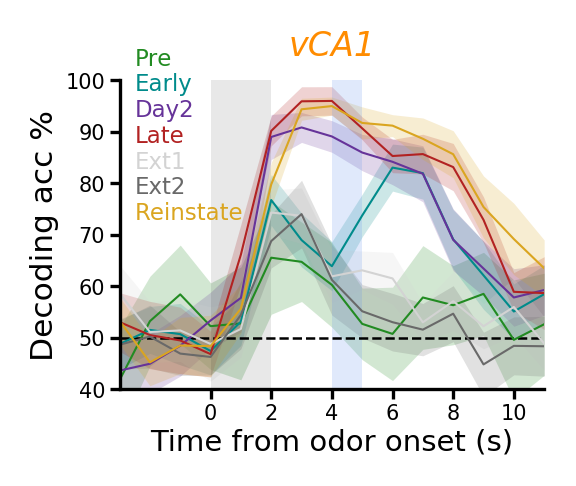

In [71]:
fig, ax = pl.subplots(1,1,figsize=(2,1.7))
reg='vhpc'
for sess,co,la,mf in zip(sessions,dark_co,session_labels,range(len(sessions))):    
    ax.plot([(t-4) for t in range(16)], [(np.mean(eval("scores_gmin_%s_%s[sess][:10]"%(reg,t)))*100) for t in range(16)], color=co,
            label=la,linestyle='-')
    m = np.array([(np.mean(eval("scores_gmin_%s_%s[sess][:10]"%(reg,t)))*100) for t in range(16)])
    s = np.array([np.std(eval("scores_gmin_%s_%s[sess][:10]"%(reg,t)))*100 for t in range(16)])
    ax.fill_between([(t-4) for t in range(16)],m-s,m+s,alpha=.2,color=co,linewidth=0)
    ax.text(-2.5,103-(5*mf),la,color=co,fontsize=5.5)
#for t in range(1,16):
#    add_significance_line(ax, eval("mean_scores_gmin_tb_%s_vhpc['ext2'][:10]"%t), eval("mean_scores_gmin_tb_%s_vhpc['renew'][:10]"%t),
#                         t-4.5, t-3.5, 101,color1=dark_co[4],color2=dark_co[-1],thresh=.01,lines=True,stars=False,sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1)
    #add_significance_line(ax, array1, array2, x1, x2, y, color1='b',color2='r',thresh=0.05, sig_func=None, thresholds=(0.05, 0.01, 0.001),lines=True,stars=True,mcc=1):
ax.set_ylim(40, 100)
ax.set_xlim(-3, 11)
ax.tick_params(axis='both',pad=1,length=2.5)
ax.set_xticks(np.arange(0,11, 2))
ax.set_xticklabels(np.arange(0,11, 2))
ax.hlines(50, -3,11, color='k', lw=.6, linestyles='dashed')
ax.set_xlabel('Time from odor onset (s)',labelpad=1)
ax.set_ylabel('Decoding acc %',fontsize=7.5,labelpad=1.5)
pt.plot_period_bar(ax, 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
pt.plot_period_bar(ax, 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
ax.set_title('vCA1', color='darkorange',fontstyle='italic',fontsize=8)
#ax.legend(loc=(.02,.66),frameon=False)
fig.tight_layout(pad=2)


#fig.savefig('../final-ish figures/%s_gmin_PoExRe_vCA1.pdf'%NOTEBOOK_NAME)

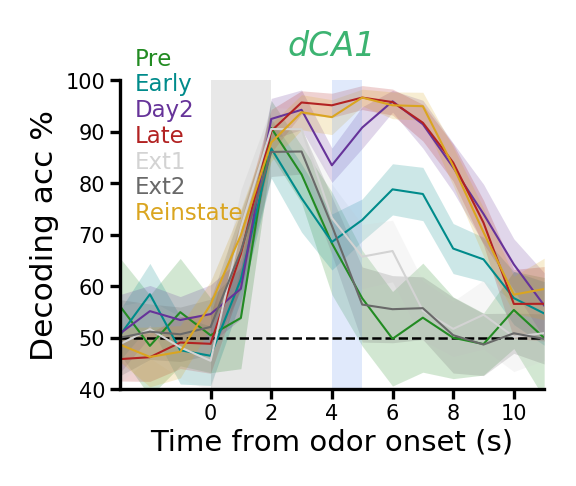

In [72]:
fig, ax = pl.subplots(1,1,figsize=(2,1.7))
reg='dhpc'
for sess,co,la,mf in zip(sessions,dark_co,session_labels,range(len(sessions))):    
    ax.plot([(t-4) for t in range(16)], [(np.mean(eval("scores_gmin_%s_%s[sess][:10]"%(reg,t)))*100) for t in range(16)], color=co,
            label=la,linestyle='-')
    m = np.array([(np.mean(eval("scores_gmin_%s_%s[sess][:10]"%(reg,t)))*100) for t in range(16)])
    s = np.array([np.std(eval("scores_gmin_%s_%s[sess][:10]"%(reg,t)))*100 for t in range(16)])
    ax.fill_between([(t-4) for t in range(16)],m-s,m+s,alpha=.2,color=co,linewidth=0)
    ax.text(-2.5,103-(5*mf),la,color=co,fontsize=5.5)
#for t in range(1,16):
#    add_significance_line(ax, eval("mean_scores_gmin_tb_%s_vhpc['ext2'][:10]"%t), eval("mean_scores_gmin_tb_%s_vhpc['renew'][:10]"%t),
#                         t-4.5, t-3.5, 101,color1=dark_co[4],color2=dark_co[-1],thresh=.01,lines=True,stars=False,sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1)
    #add_significance_line(ax, array1, array2, x1, x2, y, color1='b',color2='r',thresh=0.05, sig_func=None, thresholds=(0.05, 0.01, 0.001),lines=True,stars=True,mcc=1):
ax.set_ylim(40, 100)
ax.set_xlim(-3, 11)
ax.tick_params(axis='both',pad=1,length=2.5)
ax.set_xticks(np.arange(0,11, 2))
ax.set_xticklabels(np.arange(0,11, 2))
ax.hlines(50, -3,11, color='k', lw=.6, linestyles='dashed')
ax.set_xlabel('Time from odor onset (s)',labelpad=1)
ax.set_ylabel('Decoding acc %',fontsize=7.5,labelpad=1.5)
pt.plot_period_bar(ax, 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
pt.plot_period_bar(ax, 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
ax.set_title('dCA1', color='mediumseagreen',fontstyle='italic',fontsize=8)
#ax.legend(loc=(.02,.66),frameon=False)
fig.tight_layout(pad=2)


#fig.savefig('../final-ish figures/%s_gmin_PoExRe_vCA1.pdf'%NOTEBOOK_NAME)

# now decode each animal individually

In [30]:
from sklearn.svm import LinearSVC
decodor = LinearSVC()
from sklearn.model_selection import cross_val_score, LeaveOneOut

for reg in regions:
    for sess in sessions:
        print reg,sess,"...  ",
        for t in range(16): # number of time bins
            exec("individ_scores_%s_%s_%s={}"%(reg,sess,t))
            for ani in eval("patterns_%s_%s_%s.keys()"%(reg,sess,t)):
                exec("individ_scores_%s_%s_%s[ani]=np.r_[[(cross_val_score(decodor,patterns_%s_%s_%s[ani],labels_%s_%s[ani],\
                              cv=LeaveOneOut()))]]"%(reg,sess,t,reg,sess,t,reg,sess))

dhpc expo ...   dhpc pre ...   dhpc d2 ...   dhpc post ...   dhpc ext1 ...   dhpc ext2 ...   dhpc renew ...   vhpc expo ...   vhpc pre ...   vhpc d2 ...   vhpc post ...   vhpc ext1 ...   vhpc ext2 ...   vhpc renew ...  


In [118]:
%%time
for reg in regions:
    for sess in sessions:
        print reg,sess,"...  ",
        for t in range(16): # number of time bins
            exec("k_individ_scores_%s_%s_%s={}"%(reg,sess,t))
            for ani in eval("patterns_%s_%s_%s.keys()"%(reg,sess,t)):
                exec("k_individ_scores_%s_%s_%s[ani]=np.r_[[(cross_val_score(decodor,patterns_%s_%s_%s[ani],labels_%s_%s[ani],\
                              cv=KFold(n_splits=10)))]]"%(reg,sess,t,reg,sess,t,reg,sess))

dhpc expo ...   dhpc pre ...   dhpc d2 ...   dhpc post ...   dhpc ext1 ...   dhpc ext2 ...   dhpc renew ...   vhpc expo ...   vhpc pre ...   vhpc d2 ...   vhpc post ...   vhpc ext1 ...   vhpc ext2 ...   vhpc renew ...  CPU times: user 58.9 s, sys: 112 ms, total: 59 s
Wall time: 58.9 s



In [119]:
(k_individ_scores_vhpc_renew_6['93b'])

array([[ 0.75      ,  0.83333333,  0.91666667,  0.75      ,  0.91666667,
         0.75      ,  0.75      ,  0.66666667,  0.75      ,  0.75      ]])

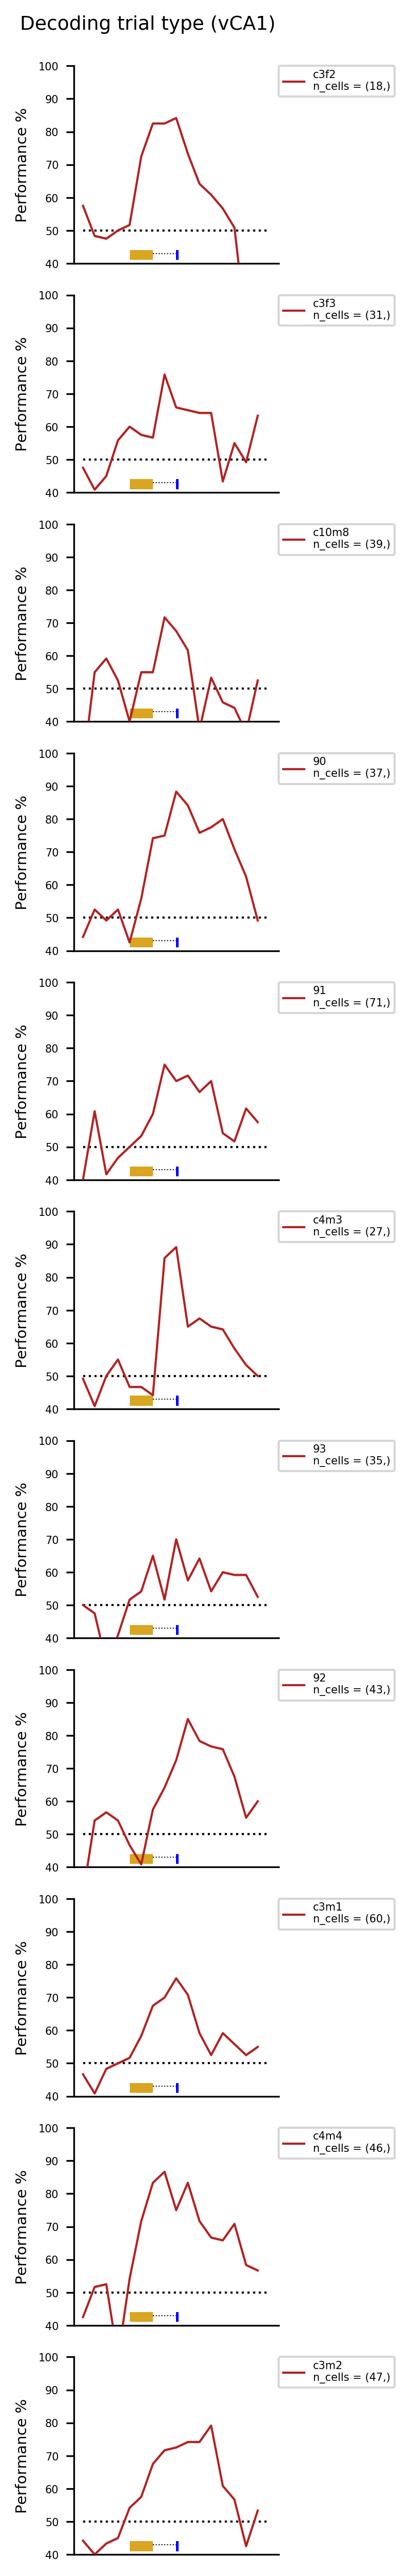

In [107]:
ses = 'post'
reg='vhpc'
fig, ax = pl.subplots(len(eval("labels_%s_%s.keys()"%(reg,ses))),1, figsize=(2, 1.5*len(eval("labels_%s_%s.keys()"%(reg,ses)))))

#for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
for y,key in zip(range(len(eval("labels_%s_%s.keys()"%(reg,ses)))),eval("labels_%s_%s.keys()"%(reg,ses))):
    #try:
        ax[y].plot([(t-4) for t in range(16)], [(np.mean(eval("individ_scores_%s_%s_%s[key]"%(reg,ses,t)))*100) for t in range(16)],
                   label=str(key)+"\nn_cells = "+str(np.shape(eval("patterns_%s_%s_%s[key]"%(reg,ses,t))[-1])),color=dark_co[-4], ls='-',lw=1, zorder=19 ,ms=1)
        m = np.array([(np.mean(eval("individ_scores_%s_%s_%s[key]"%(reg,ses,t)))*100) for t in range(16)])
        #s = np.array([np.std(eval("individ_scores_%s_%s_%s_%s['c18m9']"%(comp,tb,sess,t,)))*100 for t in range(16)])
        SEM = np.array([(np.std(eval("individ_scores_%s_%s_%s[key]"%(reg,ses,t)))/(eval("individ_scores_%s_%s_%s[key]"%(reg,ses,t)).shape[1]))*100 for t in range(16)])
        ax[y].fill_between([(t-4) for t in range(16)],m-SEM,m+SEM,alpha=0.2,color=dark_co[-4],linewidth=0)
        #ax[y].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
    #except:
    #    continue
for y,key in zip(range(len(eval("labels_%s_%s.keys()"%(reg,ses)))),eval("labels_%s_%s.keys()"%(reg,ses))):
        ax[y].set_ylim(40, 100)
        #ax[y][x].set_xlim(-3, bin_ranges[x])
        #ax[y][x].set_xticks(np.arange(-2,11, 1))
        #ax[y][x].set_xticklabels(np.arange(-2,11, .5))
        ax[y].hlines(50, -4,16-4, color='k', lw=1, linestyles='dotted')
        #ax[y][x].set_xlabel('Time from odor onset (s)')
        ax[y].set_ylabel('Performance %')
        pt.plot_period_bar(ax[y], 41, start_end=(0, 2), color='goldenrod', delta_y=3)
        pt.plot_period_bar(ax[y], 41, start_end=(4, 4.2), color='b', delta_y=3)
        ax[y].hlines(41+2, 2, 4, color='k', lw=0.5, linestyles='dotted')
        ax[y].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        ax[y].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
#ax[0][3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding trial type (vCA1)", fontsize=9, y=1.01)

fig.tight_layout(pad=2)

#fig.savefig('../figures/%s_runVSrun_individ.jpg'%NOTEBOOK_NAME)

In [137]:
def plot_1(ax, values, animals, color='k', chance=100./2):
    pt.plot_bars(np.r_[values]*100, ax=ax, colors=color, stderr=True)
    ax.hlines(chance, -1.2, len(animals)+.2, linestyles='dotted', lw=1)
    ax.set_xticks(range(len(animals)))
    ax.set_xticklabels(animals, fontsize=5, rotation=90)
    ax.set_ylim(0,100)
    try:
        return ax, [pt.add_significance(ax, v*100, chance, i, i, 105, sig_func=sstats.ttest_1samp, ticksize=0)
                    for i, v in enumerate(values)]
    except:
        None

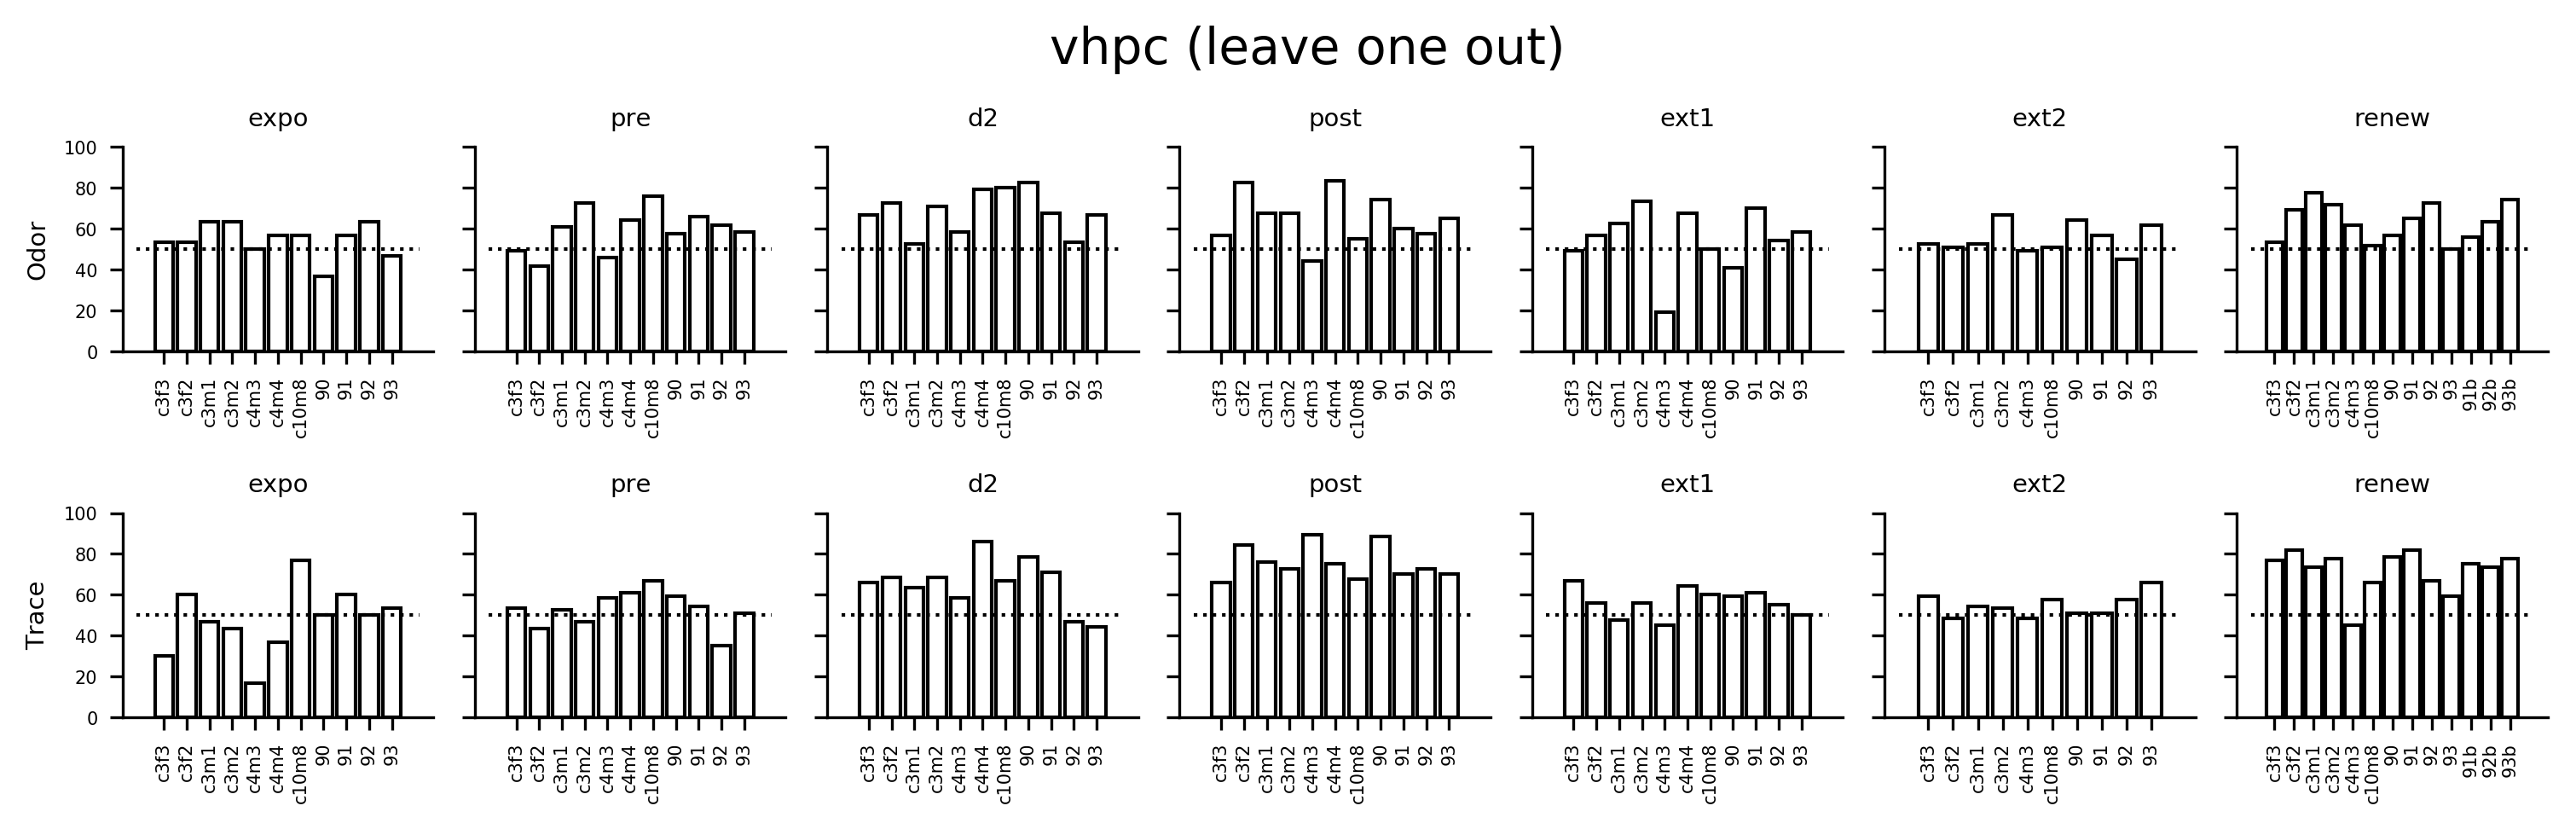

In [132]:
fig, axs = pl.subplots(2, len(sessions), figsize=(10, 3), sharey=True, sharex=False)
reg='vhpc'

pvs = []
for sess,y in zip(sessions,range(len(sessions))):
    for t,x in zip([6,8],[0,1]):
        pvs.append(plot_1(axs[x][y], [eval("individ_scores_%s_%s_%s[ani]"%(reg,sess,t)) for ani in eval("%s_%s_animals"%(reg,sess))],
                      eval("%s_%s_animals"%(reg,sess)), color='k'))
        axs[x][y].set_title(sess)
#pvs.append(plot_1(axs[0][0], [perf_pre[m] for m in pre_animals
#                      if m in perf_pre.keys()], pre_animals, color='k')[1])

for ax in axs.flatten():
    pt.nicer_plot(ax)
fig.tight_layout(pad=2)
axs[0][0].set_ylabel('Odor')
axs[1][0].set_ylabel('Trace')
fig.suptitle(reg+" (leave one out)",y=1.06,fontsize=14)
#
#fig.savefig('../img/%s.jpg'%NOTEBOOK_NAME)


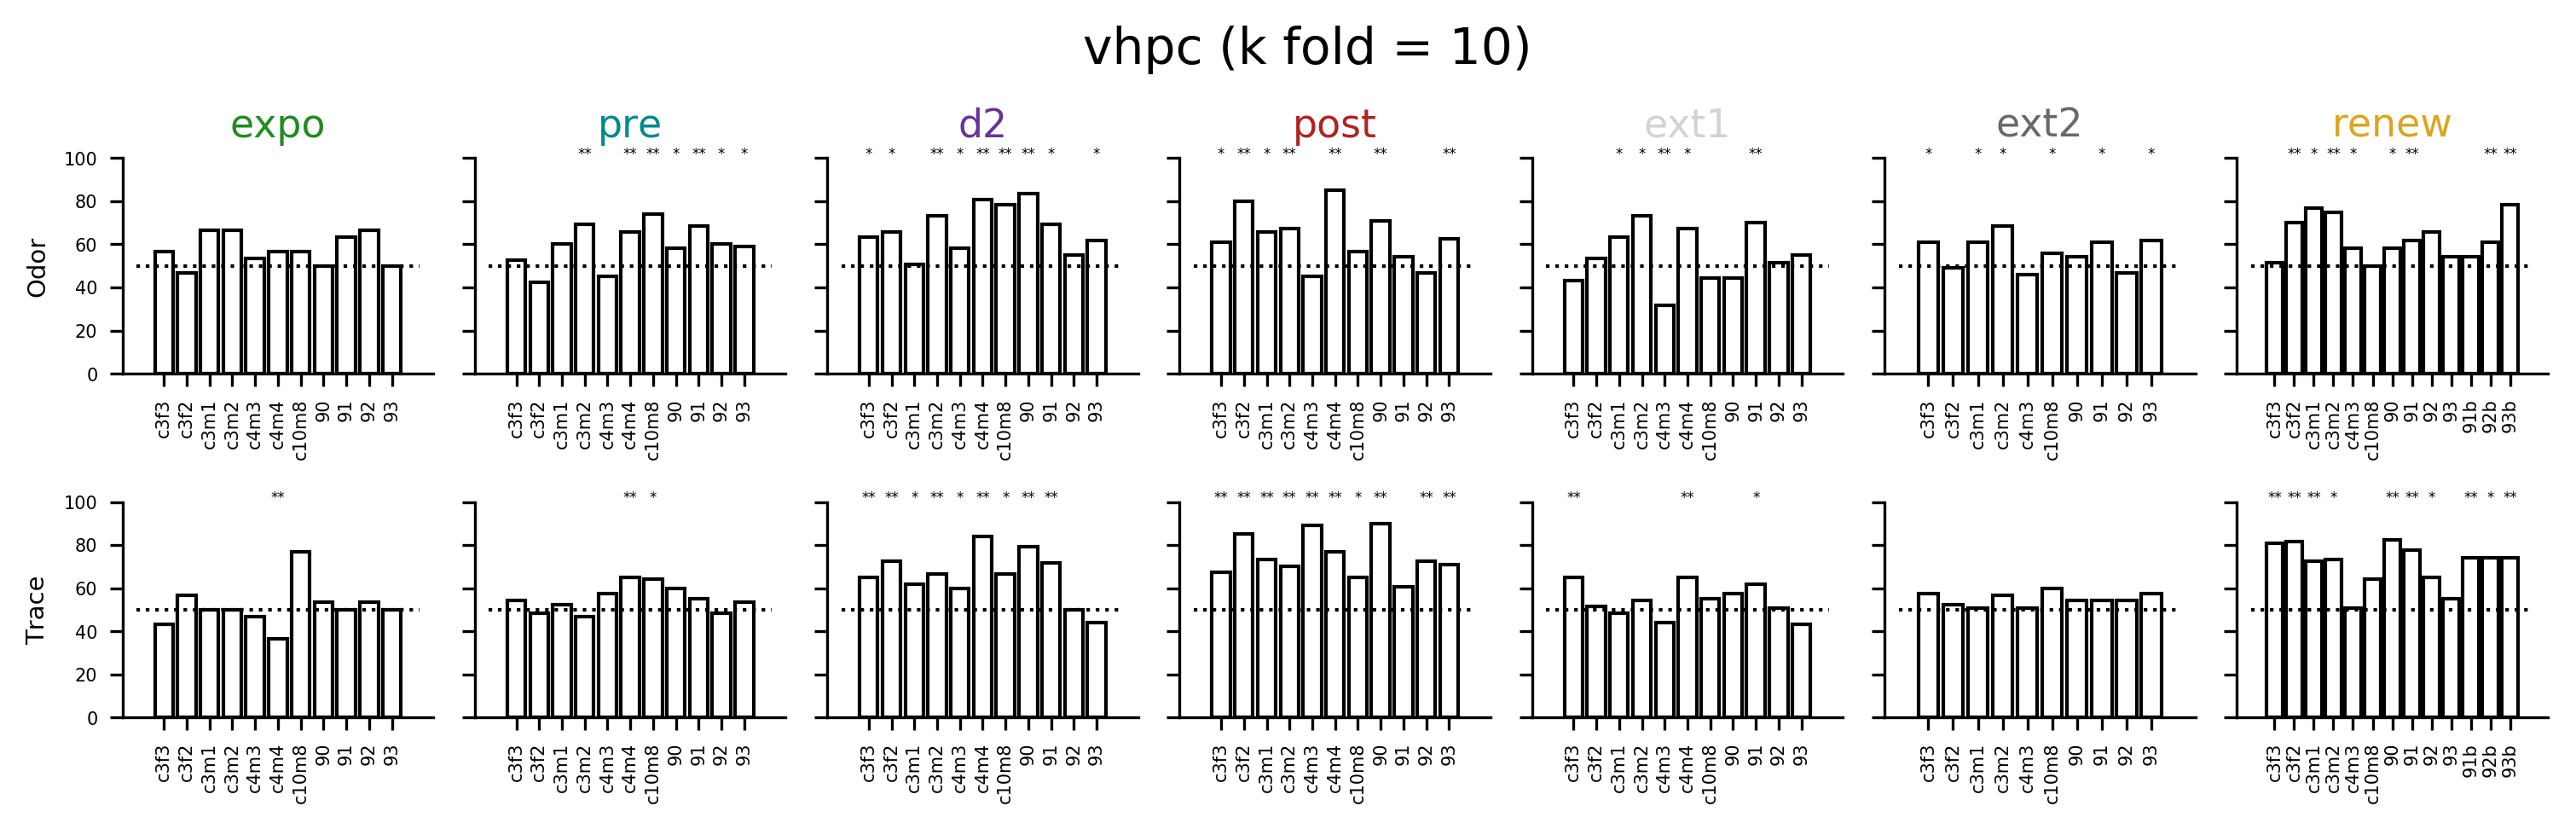

In [168]:
fig, axs = pl.subplots(2, len(sessions), figsize=(10, 3), sharey=True, sharex=False)
reg='vhpc'

pvs = []
for sess,y in zip(sessions,range(len(sessions))):
    for t,x in zip([6,8],[0,1]):
        pvs.append(plot_1(axs[x][y], [eval("k_individ_scores_%s_%s_%s[ani]"%(reg,sess,t)) for ani in eval("%s_%s_animals"%(reg,sess))],
                      eval("%s_%s_animals"%(reg,sess)), color='k'))
        for i,ani in enumerate(eval("%s_%s_animals"%(reg,sess))):
            pvs.append(sig_vs_chance(axs[x][y],eval("k_individ_scores_%s_%s_%s[ani][-1]"%(reg,sess,t)),
                                 .5,i,100,sig_func=None,colors='k'))
        axs[0][y].set_title(sess,color=dark_co[y],fontsize=11)
#pvs.append(plot_1(axs[0][0], [perf_pre[m] for m in pre_animals
#                      if m in perf_pre.keys()], pre_animals, color='k')[1])

for ax in axs.flatten():
    pt.nicer_plot(ax)
fig.tight_layout(pad=2)
axs[0][0].set_ylabel('Odor')
axs[1][0].set_ylabel('Trace')
fig.suptitle(reg+" (k fold = 10)",y=1.06,fontsize=14)
#
#fig.savefig('../img/%s.jpg'%NOTEBOOK_NAME)


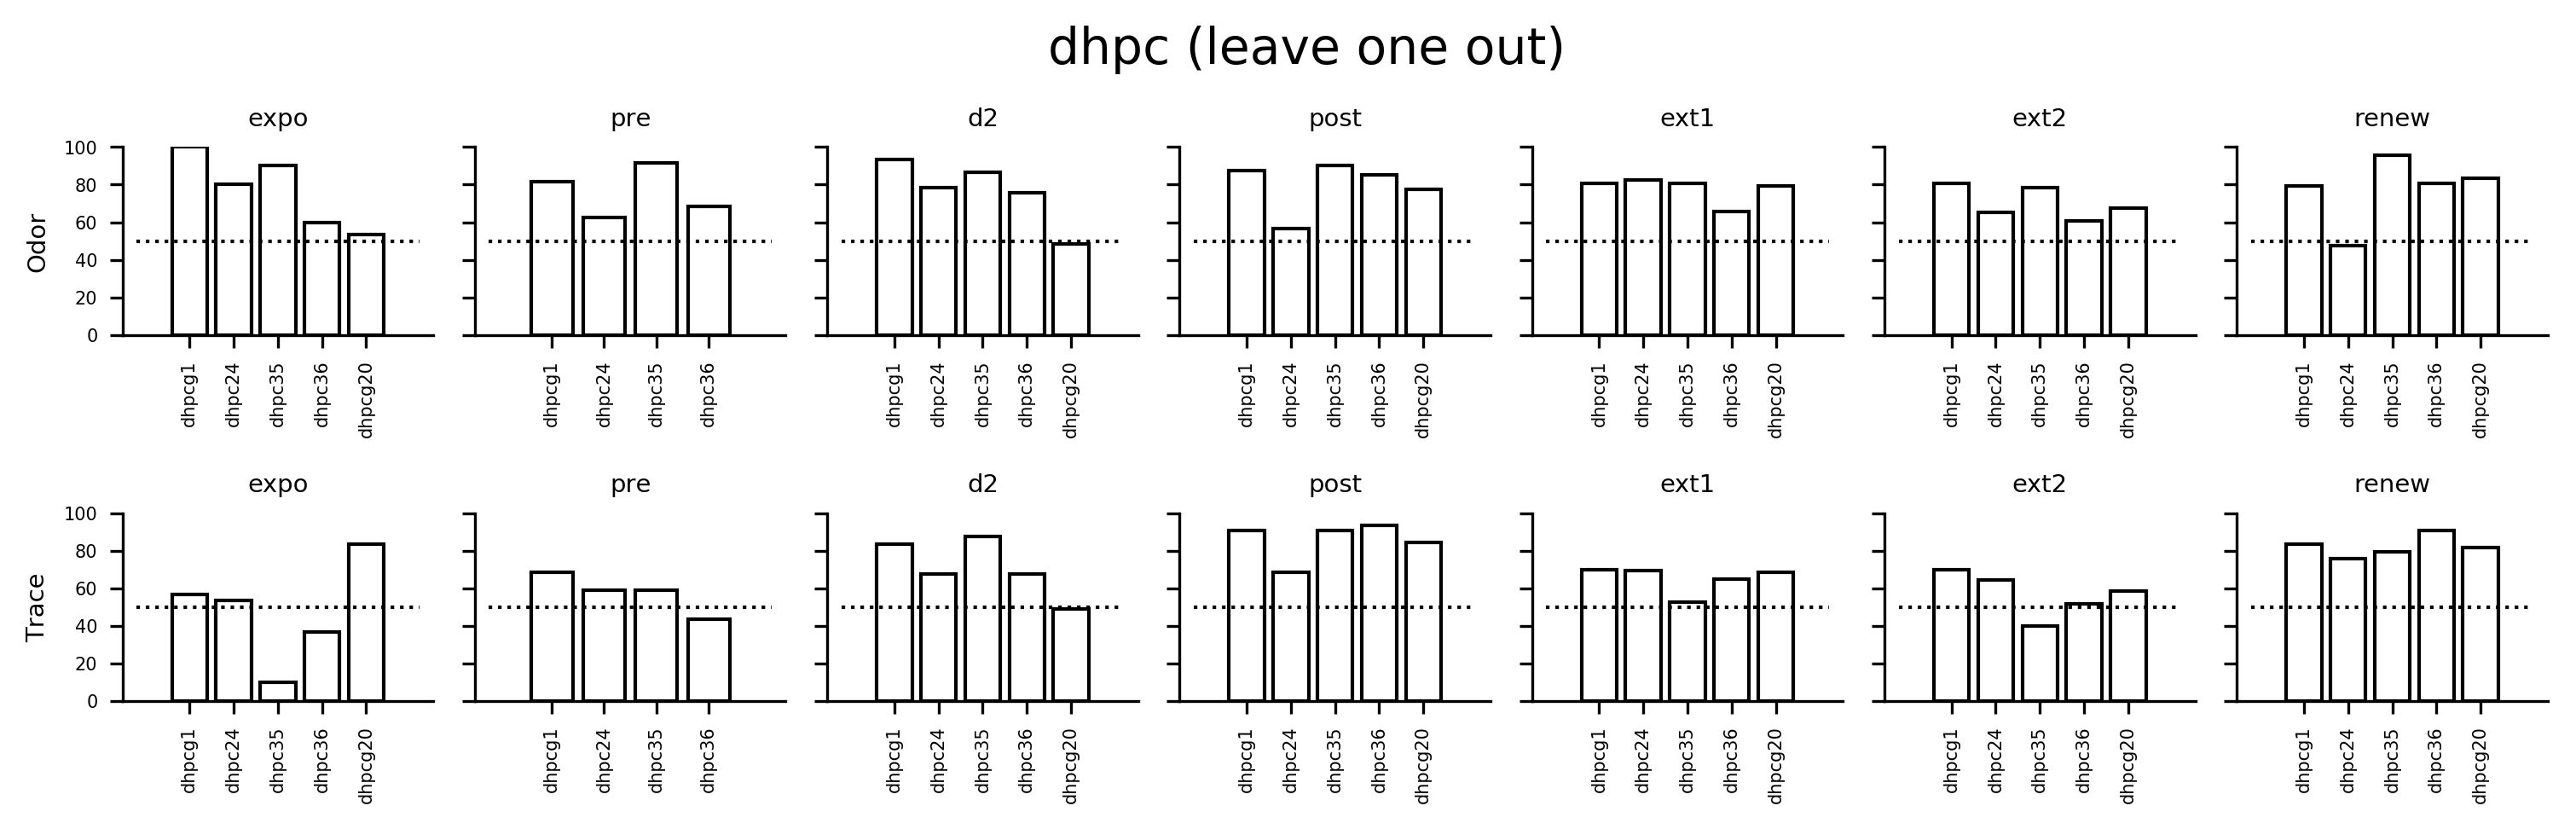

In [114]:
fig, axs = pl.subplots(2, len(sessions), figsize=(10, 3), sharey=True, sharex=False)
reg='dhpc'

pvs = []
for sess,y in zip(sessions,range(len(sessions))):
    for t,x in zip([6,8],[0,1]):
        pvs.append(plot_1(axs[x][y], [eval("individ_scores_%s_%s_%s[ani]"%(reg,sess,t)) for ani in eval("%s_%s_animals"%(reg,sess))],
                      eval("%s_%s_animals"%(reg,sess)), color='k'))
        axs[x][y].set_title(sess)
#pvs.append(plot_1(axs[0][0], [perf_pre[m] for m in pre_animals
#                      if m in perf_pre.keys()], pre_animals, color='k')[1])

for ax in axs.flatten():
    pt.nicer_plot(ax)
fig.tight_layout(pad=2)
axs[0][0].set_ylabel('Odor')
axs[1][0].set_ylabel('Trace')
fig.suptitle(reg+" (leave one out)",y=1.06,fontsize=14)
#
#fig.savefig('../img/%s.jpg'%NOTEBOOK_NAME)


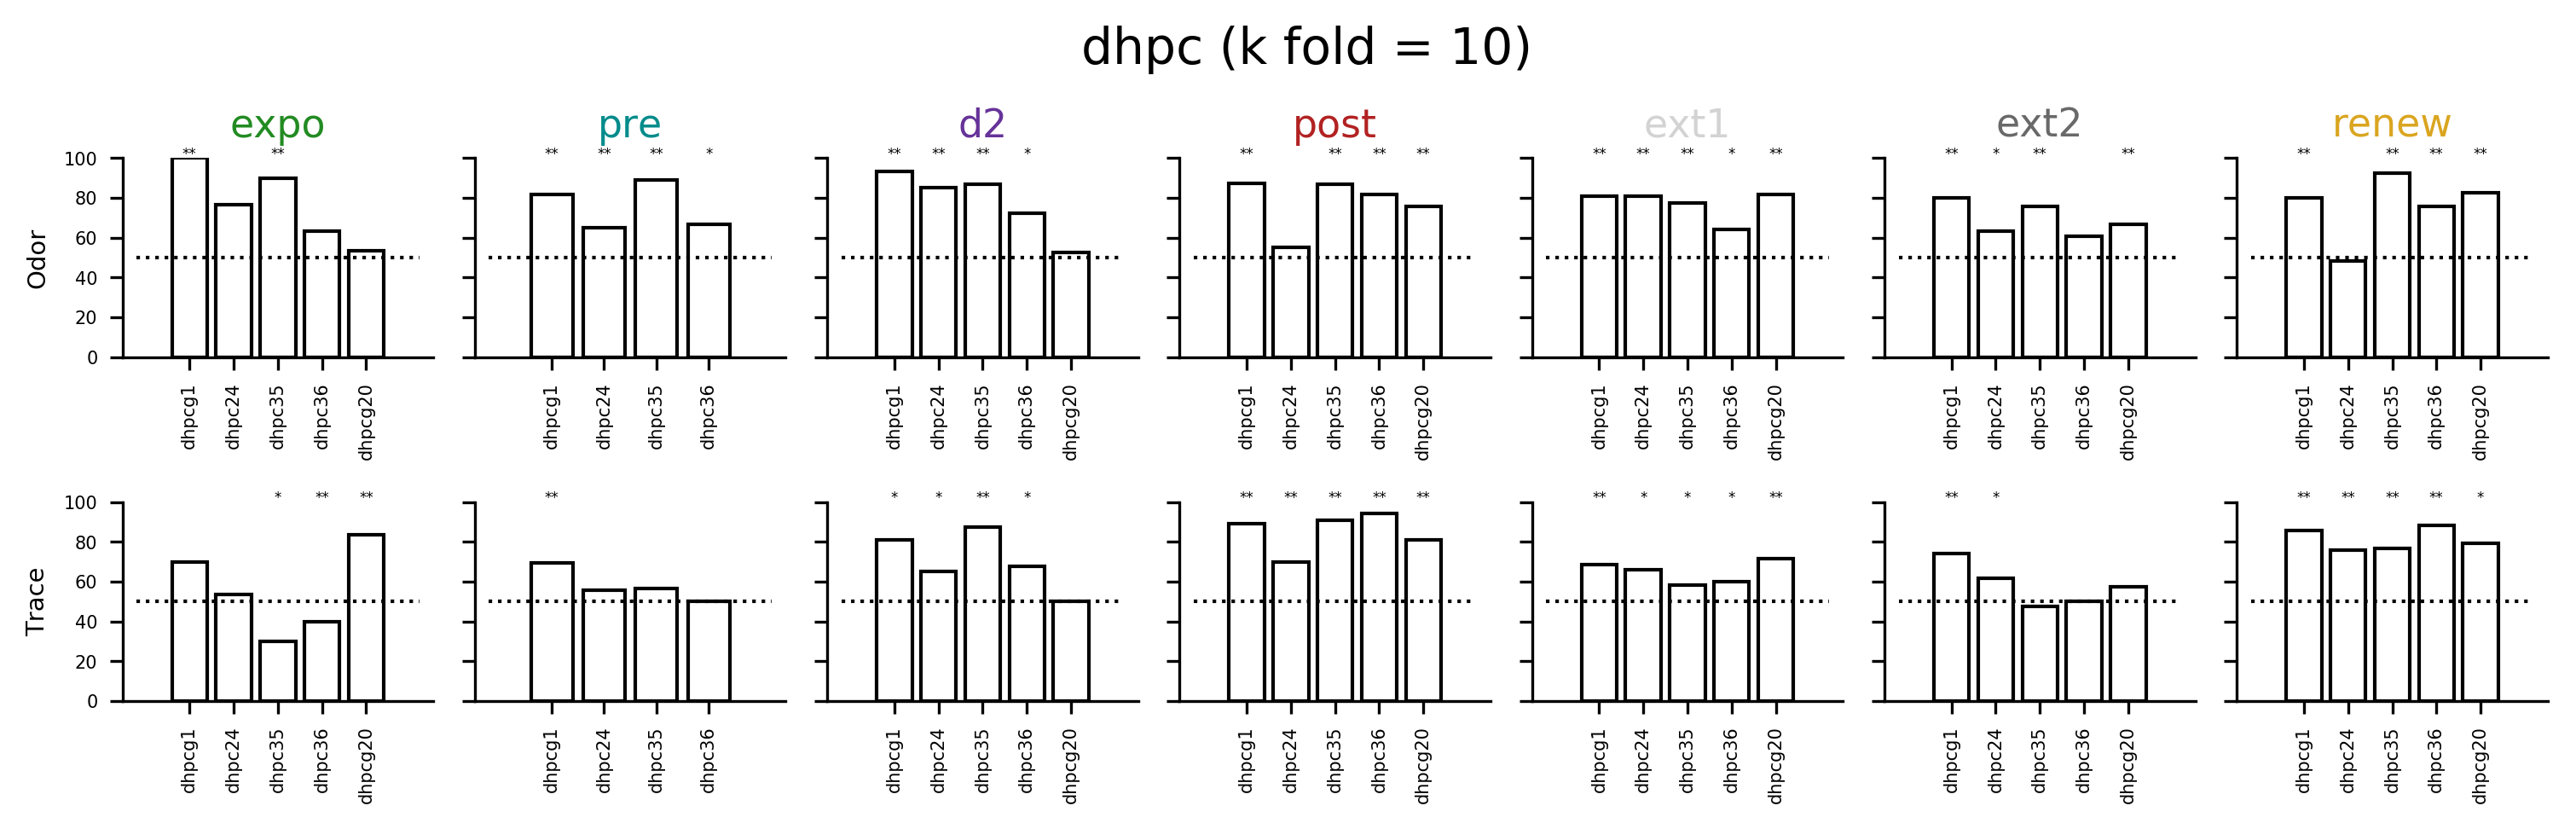

In [232]:
fig, axs = pl.subplots(2, len(sessions), figsize=(10, 3), sharey=True, sharex=False)
reg='dhpc'

pvs = []
for sess,y in zip(sessions,range(len(sessions))):
    for t,x in zip([6,8],[0,1]):
        pvs.append(plot_1(axs[x][y], [eval("k_individ_scores_%s_%s_%s[ani]"%(reg,sess,t)) for ani in eval("%s_%s_animals"%(reg,sess))],
                      eval("%s_%s_animals"%(reg,sess)), color='k'))
        for i,ani in enumerate(eval("%s_%s_animals"%(reg,sess))):
            pvs.append(sig_vs_chance(axs[x][y],eval("k_individ_scores_%s_%s_%s[ani][-1]"%(reg,sess,t)),
                                 .5,i,100,sig_func=None,colors='k'))
        axs[0][y].set_title(sess,color=dark_co[y],fontsize=11)
#pvs.append(plot_1(axs[0][0], [perf_pre[m] for m in pre_animals
#                      if m in perf_pre.keys()], pre_animals, color='k')[1])

for ax in axs.flatten():
    pt.nicer_plot(ax)
fig.tight_layout(pad=2)
axs[0][0].set_ylabel('Odor')
axs[1][0].set_ylabel('Trace')
fig.suptitle(reg+" (k fold = 10)",y=1.06,fontsize=14)
#
#fig.savefig('../img/%s.jpg'%NOTEBOOK_NAME)


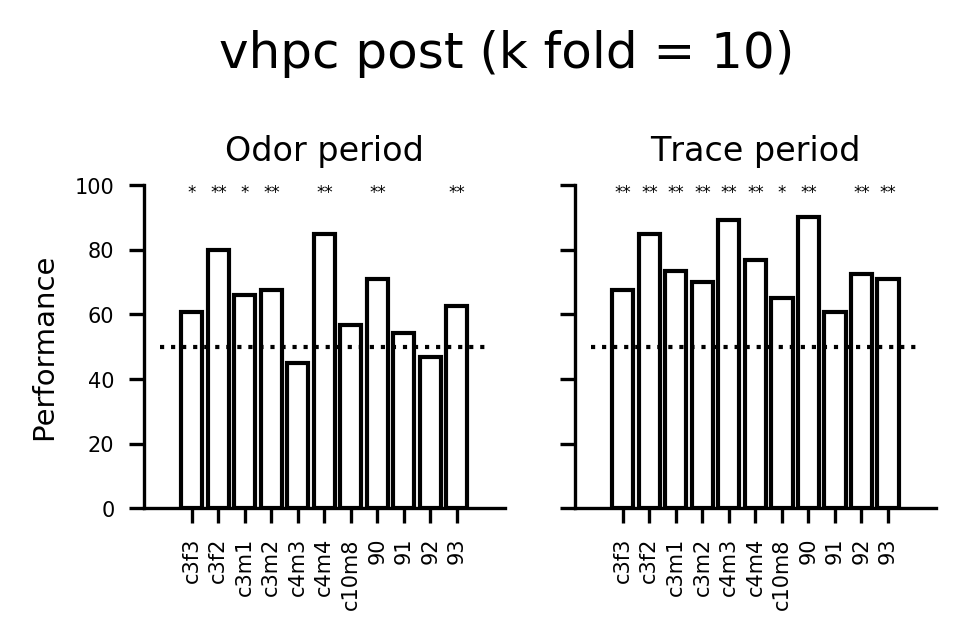

In [252]:
fig, axs = pl.subplots(1,2, figsize=(3.3, 2), sharey=True, sharex=False)
reg='vhpc'
sess='post'
pvs = []
for t,x,per in zip([6,8],[0,1],['Odor period','Trace period']):
        pvs.append(plot_1(axs[x], [eval("k_individ_scores_%s_%s_%s[ani]"%(reg,sess,t)) for ani in eval("%s_%s_animals"%(reg,sess))],
                      eval("%s_%s_animals"%(reg,sess)), color='k'))
        for i,ani in enumerate(eval("%s_%s_animals"%(reg,sess))):
            pvs.append(sig_vs_chance(axs[x],eval("k_individ_scores_%s_%s_%s[ani][-1]"%(reg,sess,t)),
                                 .5,i,96,sig_func=None,colors='k'))
        axs[x].set_title(per,fontsize=8)

fig.tight_layout(pad=3)
axs[0].set_ylabel('Performance')
fig.suptitle(reg+" "+sess+" (k fold = 10)",y=1.07,fontsize=12)
#
#fig.savefig('../img/%s.jpg'%NOTEBOOK_NAME)


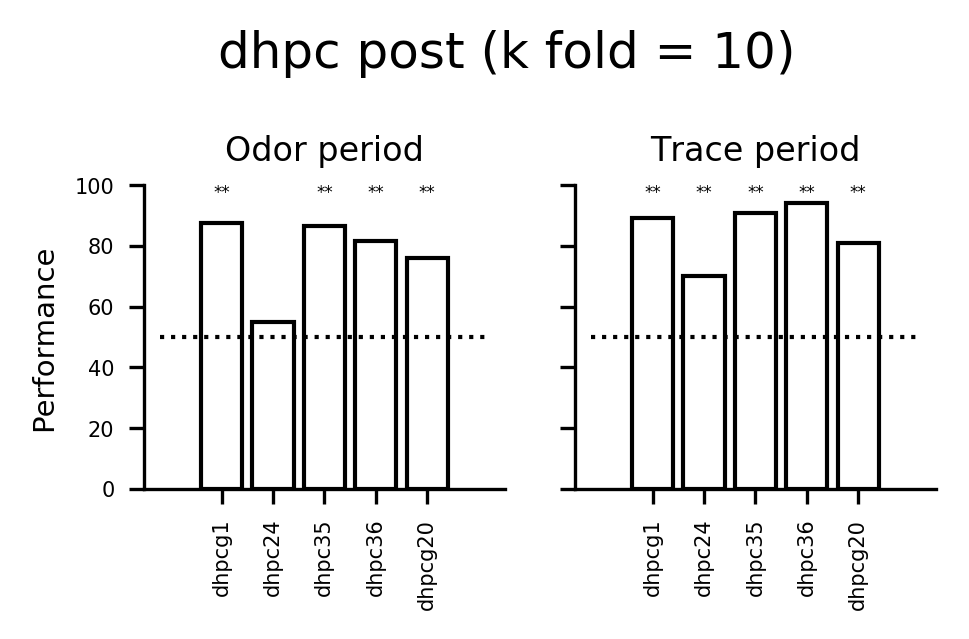

In [251]:
fig, axs = pl.subplots(1,2, figsize=(3.3, 2), sharey=True, sharex=False)
reg='dhpc'
sess='post'
pvs = []
for t,x,per in zip([6,8],[0,1],['Odor period','Trace period']):
        pvs.append(plot_1(axs[x], [eval("k_individ_scores_%s_%s_%s[ani]"%(reg,sess,t)) for ani in eval("%s_%s_animals"%(reg,sess))],
                      eval("%s_%s_animals"%(reg,sess)), color='k'))
        for i,ani in enumerate(eval("%s_%s_animals"%(reg,sess))):
            pvs.append(sig_vs_chance(axs[x],eval("k_individ_scores_%s_%s_%s[ani][-1]"%(reg,sess,t)),
                                 .5,i,96,sig_func=None,colors='k'))
        axs[x].set_title(per,fontsize=8)
#pvs.append(plot_1(axs[0][0], [perf_pre[m] for m in pre_animals
#                      if m in perf_pre.keys()], pre_animals, color='k')[1])

fig.tight_layout(pad=3)
axs[0].set_ylabel('Performance')
fig.suptitle(reg+" "+sess+" (k fold = 10)",y=1.07,fontsize=12)
#
#fig.savefig('../img/%s.jpg'%NOTEBOOK_NAME)


WilcoxonResult(statistic=4.0, pvalue=0.0099254858453232571) r = -0.78554432708
WilcoxonResult(statistic=0.0, pvalue=0.0033456181158508813) r = -0.841654636157


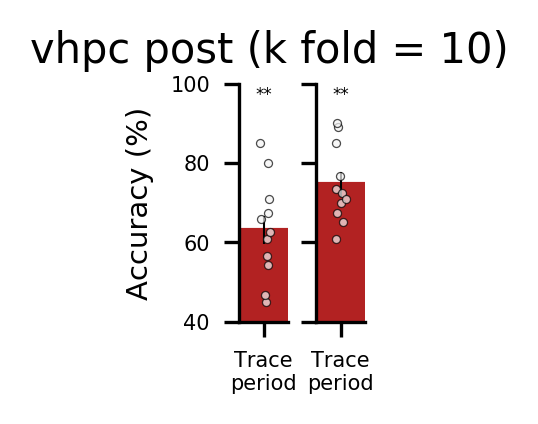

In [370]:
fig, axs = pl.subplots(1,2, figsize=(.8, 1.2), sharey=True, sharex=True)
reg='vhpc'
sess='post'
pvs = []
for t,x,per in zip([6,8],[0,1],['Odor\nperiod','Trace\nperiod']):
        axs[x].bar(0, np.mean([np.mean(eval("k_individ_scores_%s_%s_%s[ani]"%(reg,sess,t)))*100 for ani in eval("%s_%s_animals"%(reg,sess))]),
                   color='firebrick',edgecolor='firebrick',
                   yerr=(np.mean([np.std(eval("k_individ_scores_%s_%s_%s[ani]"%(reg,sess,t)))*100 for ani in eval("%s_%s_animals"%(reg,sess))]))/np.sqrt(len(eval("%s_%s_animals"%(reg,sess)))))
        axs[x].scatter(0+np.random.random(len(eval("%s_%s_animals"%(reg,sess))))*1/5-.08,[np.mean(eval("k_individ_scores_%s_%s_%s[ani]"%(reg,sess,t)))*100 for ani in eval("%s_%s_animals"%(reg,sess))],
                          color='whitesmoke',s=3.7,zorder=2,alpha=.7,linewidths=.3,edgecolor='k')
        axs[x].set_ylim(40,100)
        axs[x].set_xticks([0])
        axs[x].set_xticklabels([per])
        #axs[x].set_title(per,fontsize=7)
        pvs.append(sig_vs_chance(axs[x],[np.mean(eval("k_individ_scores_%s_%s_%s[ani][-1]"%(reg,sess,t))) for ani in eval("%s_%s_animals"%(reg,sess))],
                                 .5,0,96,sig_func=None,colors='k'))
        loops = len(eval("%s_%s_animals"%(reg,sess)))
        report_stats_chance([np.mean(eval("k_individ_scores_%s_%s_%s[ani][-1]"%(reg,sess,t))) for ani in eval("%s_%s_animals"%(reg,sess))],
                    chance=0.5,sig_func=None,mcc=1)
fig.tight_layout(pad=1)
axs[0].set_ylabel('Accuracy (%)')
fig.suptitle(reg+" "+sess+" (k fold = 10)",y=1.07,fontsize=10)

fig.savefig('../final-ish figures/%s_vhpc.pdf'%NOTEBOOK_NAME)

WilcoxonResult(statistic=0.0, pvalue=0.043114446783075355) r = -0.809039834956
WilcoxonResult(statistic=0.0, pvalue=0.043114446783075355) r = -0.809039834956


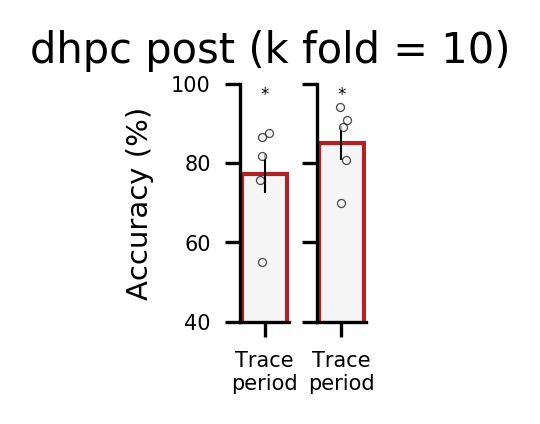

In [371]:
fig, axs = pl.subplots(1,2, figsize=(.8, 1.2), sharey=True, sharex=True)
reg='dhpc'
sess='post'
pvs = []
for t,x,per in zip([6,8],[0,1],['Odor\nperiod','Trace\nperiod']):
        axs[x].bar(0, np.mean([np.mean(eval("k_individ_scores_%s_%s_%s[ani]"%(reg,sess,t)))*100 for ani in eval("%s_%s_animals"%(reg,sess))]),
                   color='whitesmoke',edgecolor='firebrick',
                   yerr=(np.mean([np.std(eval("k_individ_scores_%s_%s_%s[ani]"%(reg,sess,t)))*100 for ani in eval("%s_%s_animals"%(reg,sess))]))/np.sqrt(len(eval("%s_%s_animals"%(reg,sess)))))
        axs[x].scatter(0+np.random.random(len(eval("%s_%s_animals"%(reg,sess))))*1/5-.08,[np.mean(eval("k_individ_scores_%s_%s_%s[ani]"%(reg,sess,t)))*100 for ani in eval("%s_%s_animals"%(reg,sess))],
                          color='whitesmoke',s=3.7,zorder=2,alpha=.7,linewidths=.3,edgecolor='k')
        axs[x].set_ylim(40,100)
        axs[x].set_xticks([0])
        axs[x].set_xticklabels([per])
        #axs[x].set_title(per,fontsize=7)
        pvs.append(sig_vs_chance(axs[x],[np.mean(eval("k_individ_scores_%s_%s_%s[ani][-1]"%(reg,sess,t))) for ani in eval("%s_%s_animals"%(reg,sess))],
                                 .5,0,96,sig_func=None,colors='k'))
        loops = len(eval("%s_%s_animals"%(reg,sess)))
        report_stats_chance([np.mean(eval("k_individ_scores_%s_%s_%s[ani][-1]"%(reg,sess,t))) for ani in eval("%s_%s_animals"%(reg,sess))],
                    chance=0.5,sig_func=None,mcc=1)

fig.tight_layout(pad=1)
axs[0].set_ylabel('Accuracy (%)')
fig.suptitle(reg+" "+sess+" (k fold = 10)",y=1.07,fontsize=10)
fig.savefig('../final-ish figures/%s_dhpc.pdf'%NOTEBOOK_NAME)

In [225]:
from numpy.polynomial.polynomial import polyfit

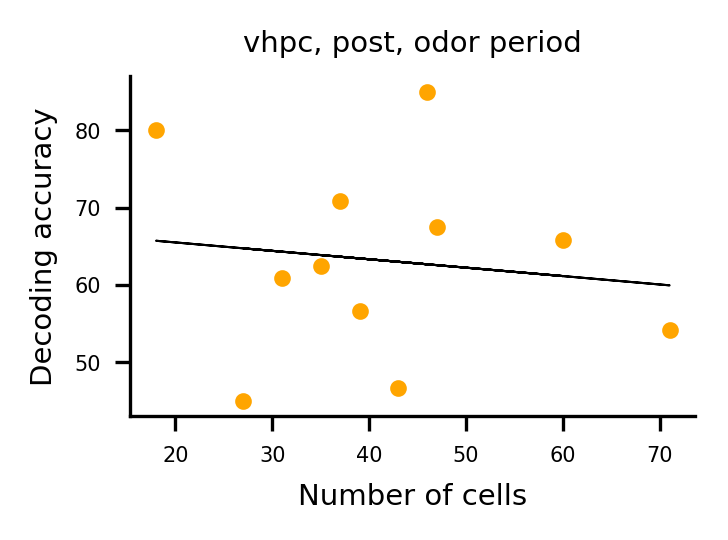

In [227]:
reg='vhpc'
ses='post'
t=6
c='orange'
x = np.r_[[np.shape(eval("patterns_%s_%s_%s[ani]"%(reg,ses,t)))[-1] for ani in eval("%s_%s_animals"%(reg,ses))]]
y = np.r_[[np.mean(eval("k_individ_scores_%s_%s_%s[ani][-1]"%(reg,ses,t)))*100 for ani in eval("%s_%s_animals"%(reg,ses))]]
# Fit with polyfit
b, m = polyfit(x, y, 1)

pl.plot(x, y, '.',color=c)
pl.plot(x, b + m * x, '-',color='k')

pl.xlabel('Number of cells')
pl.ylabel('Decoding accuracy')
pl.title(reg+", "+ses+", "+'odor period')

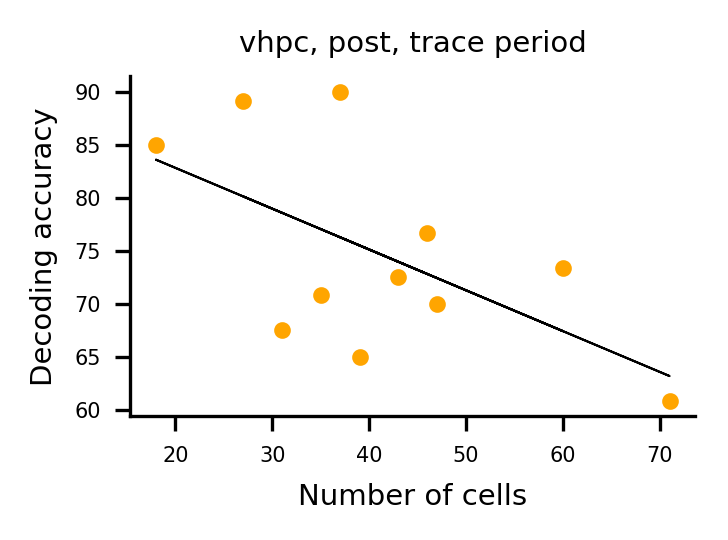

In [224]:
reg='vhpc'
ses='post'
t=8
c='orange'
x = np.r_[[np.shape(eval("patterns_%s_%s_%s[ani]"%(reg,ses,t)))[-1] for ani in eval("%s_%s_animals"%(reg,ses))]]
y = np.r_[[np.mean(eval("k_individ_scores_%s_%s_%s[ani][-1]"%(reg,ses,t)))*100 for ani in eval("%s_%s_animals"%(reg,ses))]]
# Fit with polyfit
b, m = polyfit(x, y, 1)

pl.plot(x, y, '.',color=c)
pl.plot(x, b + m * x, '-',color='k')
#pl.scatter([np.shape(eval("patterns_%s_%s_%s[ani]"%(reg,ses,t)))[-1] for ani in eval("%s_%s_animals"%(reg,ses))],
#        [np.mean(eval("k_individ_scores_%s_%s_%s[ani][-1]"%(reg,ses,t)))*100 for ani in eval("%s_%s_animals"%(reg,ses))],color='orange')
pl.xlabel('Number of cells')
pl.ylabel('Decoding accuracy')
pl.title(reg+", "+ses+", "+'trace period')

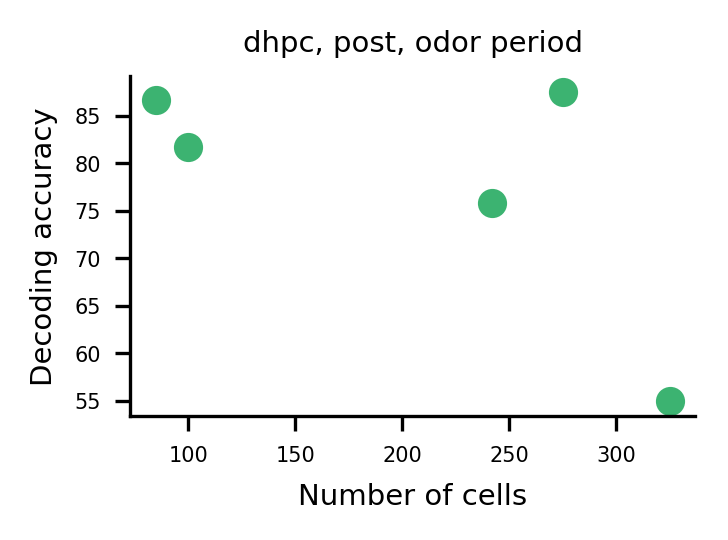

In [205]:
reg='dhpc'
ses='post'
t=6
pl.scatter([np.shape(eval("patterns_%s_%s_%s[ani]"%(reg,ses,t)))[-1] for ani in eval("%s_%s_animals"%(reg,ses))],
        [np.mean(eval("k_individ_scores_%s_%s_%s[ani][-1]"%(reg,ses,t)))*100 for ani in eval("%s_%s_animals"%(reg,ses))],color='mediumseagreen')
pl.xlabel('Number of cells')
pl.ylabel('Decoding accuracy')
pl.title(reg+", "+ses+", "+'odor period')

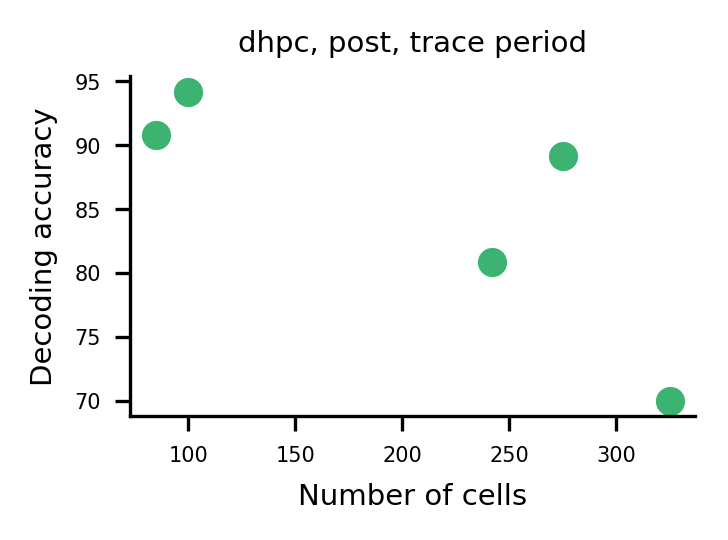

In [206]:
reg='dhpc'
ses='post'
t=8
pl.scatter([np.shape(eval("patterns_%s_%s_%s[ani]"%(reg,ses,t)))[-1] for ani in eval("%s_%s_animals"%(reg,ses))],
        [np.mean(eval("k_individ_scores_%s_%s_%s[ani][-1]"%(reg,ses,t)))*100 for ani in eval("%s_%s_animals"%(reg,ses))],color='mediumseagreen')
pl.xlabel('Number of cells')
pl.ylabel('Decoding accuracy')
pl.title(reg+", "+ses+", "+'trace period')

In [209]:
save_workspace(db)

Could not store variable 'pickle'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'np'. Skipping...
